**Cài đặt các thư viện cần thiết**

In [25]:
!pip install lightgbm optuna numpy pandas scikit-learn matplotlib tensorflow xgboost

**Import thư viện cần thiết cho xử lý dữ liệu**

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, ElasticNetCV
from sklearn.pipeline import make_pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Tiền xử lý dữ liệu và xây dựng các biến đặc trưng (MA, Momentum, Volatility, Lag)**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA/BTC_Data_final.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
df = df.dropna(subset=['priceUSD'])

df['MA7'] = df['priceUSD'].rolling(7).mean()
df['MA14'] = df['priceUSD'].rolling(14).mean()
df['ROC'] = df['priceUSD'].pct_change(1)
df['Momentum'] = df['priceUSD'] - df['priceUSD'].shift(7)
df['Volatility'] = df['priceUSD'].rolling(7).std()

for lag in [1,2,3,5,10]:
    df[f'lag_{lag}'] = df['priceUSD'].shift(lag)

df = df.dropna().reset_index(drop=True)
feature_cols = ['MA7','MA14','ROC','Momentum','Volatility'] + [f'lag_{lag}' for lag in [1,2,3,5,10]]

<ipython-input-6-c48b5d14e5c9>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


**Chia dữ liệu thành tập train-valid-test**

In [ ]:
n = len(df)
i1, i2 = int(n*0.8), int(n*0.9)
df_train, df_valid, df_test = df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

**Chuẩn hóa dữ liệu đầu vào và biến mục tiêu bằng MinMaxScaler**

In [ ]:
scaler_price = MinMaxScaler()
y_train = scaler_price.fit_transform(df_train[['priceUSD']]).ravel()
y_valid = scaler_price.transform(df_valid[['priceUSD']]).ravel()
y_test  = scaler_price.transform(df_test[['priceUSD']]).ravel()

scaler_feat = MinMaxScaler()
X_train = scaler_feat.fit_transform(df_train[feature_cols])
X_valid = scaler_feat.transform(df_valid[feature_cols])
X_test  = scaler_feat.transform(df_test[feature_cols])

**Chuẩn bị dữ liệu chuỗi đầu vào cho mô hình LSTM**

In [ ]:
window = 10
def make_seq(arr):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    return np.array(X), np.array(y)

Xtr_seq, ytr_seq = make_seq(y_train)
Xva_seq, yva_seq = make_seq(y_valid)
Xte_seq, yte_seq = make_seq(y_test)

Xtr_feat = X_train[window:]
Xva_feat = X_valid[window:]
Xte_feat = X_test[window:]

**Tối ưu siêu tham số mô hình LSTM bằng Optuna**

In [ ]:
def objective_lstm(trial):
    n_units = trial.suggest_int('n_units', 32, 128)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = Sequential([
        LSTM(n_units, input_shape=(window,1)),
        Dropout(dropout),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        Xtr_seq.reshape(-1,window,1), ytr_seq,
        validation_data=(Xva_seq.reshape(-1,window,1), yva_seq),
        epochs=50,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=30, show_progress_bar=True)

print("Best LSTM params:", study_lstm.best_trial.params)

[I 2025-05-24 02:45:21,600] A new study created in memory with name: no-name-c2961b30-741c-488c-baf7-7d807d1809ad


  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-13-4308e143ef8a>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-05-24 02:46:08,070] Trial 0 finished with value: 0.0007639528485015035 and parameters: {'n_units': 121, 'dropout': 0.13692959359632761, 'learning_rate': 0.0024069152079288147, 'batch_size': 32}. Best is trial 0 with value: 0.0007639528485015035.
[I 2025-05-24 02:46:37,861] Trial 1 finished with value: 0.0009311408502981067 and parameters: {'n_units': 124, 'dropout': 0.14117267907304962, 'learning_rate': 0.004604317392054979, 'batch_size': 64}. Best is trial 0 with value: 0.0007639528485015035.
[I 2025-05-24 02:47:33,106] Trial 2 finished with value: 0.0008978305850178003 and parameters: {'n_units': 71, 'dropout': 0.10815729227517377, 'learning_rate': 0.0010246496926074422, 'batch_size': 32}. Best is trial 0 with value: 0.0007639528485015035.
[I 2025-05-24 02:48:44,767] Trial 3 finished with value: 0.001454541110433638 and parameters: {'n_units': 125, 'dropout': 0.4225535506649408, 'learning_rate': 0.0005100955462216373, 'batch_size': 32}. Best is trial 0 with value: 0.000763952

**Huấn luyện mô hình LSTM cuối cùng với siêu tham số tối ưu**

In [ ]:
best_lstm_params = study_lstm.best_trial.params
model_lstm = Sequential([
    LSTM(best_lstm_params['n_units'], input_shape=(window,1)),
    Dropout(best_lstm_params['dropout']),
    Dense(1)
])
optimizer = Adam(learning_rate=best_lstm_params['learning_rate'])
model_lstm.compile(optimizer=optimizer, loss='mse')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_lstm.fit(
    Xtr_seq.reshape(-1,window,1), ytr_seq,
    validation_data=(Xva_seq.reshape(-1,window,1), yva_seq),
    epochs=50,
    batch_size=best_lstm_params['batch_size'],
    callbacks=[es],
    verbose=1
)

pred_lstm_val = model_lstm.predict(Xva_seq.reshape(-1,window,1)).ravel()
pred_lstm_test = model_lstm.predict(Xte_seq.reshape(-1,window,1)).ravel()

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4667e-04 - val_loss: 0.0017
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.8472e-04 - val_loss: 0.0068
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.1145e-04 - val_loss: 0.0015
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.2980e-04 - val_loss: 0.0037
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2480e-04 - val_loss: 0.0012
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8339e-04 - val_loss: 0.0053
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8270e-04 - val_loss: 0.0095
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.3351e-04 - val_loss: 9.4620e-04
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9371e-04 - val_loss: 0.0012
Epoch 11/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.2452e-04 - val_loss: 0.0013


**Tối ưu siêu tham số mô hình LightGBM bằng Optuna với Cross-validation**

In [ ]:
def objective_lgb(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
        'seed': 42,
        'verbosity': -1,
    }
    dtrain = lgb.Dataset(Xtr_feat, label=ytr_seq)
    cv_results = lgb.cv(
        param, dtrain, nfold=5, stratified=False, metrics='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30)]
    )
    return min(cv_results['valid rmse-mean'])

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print("Best LightGBM params:", study_lgb.best_trial.params)

[I 2025-05-24 03:08:17,952] A new study created in memory with name: no-name-6e6efc14-47e0-4fa4-831b-cc294045c827


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-15-96d3f5fafa7b>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-15-96d3f5fafa7b>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-15-96d3f5fafa7b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
<ipython-input-15-96d3f5fafa7b>:13: FutureWarning: suggest_uniform has been deprecated in

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's valid rmse: 0.0926218 + 0.0159802
[I 2025-05-24 03:08:18,322] Trial 0 finished with value: 0.09262179433390781 and parameters: {'lambda_l1': 0.1431365621508049, 'lambda_l2': 0.36865174304814413, 'num_leaves': 86, 'feature_fraction': 0.8116220484072676, 'bagging_fraction': 0.6704641471607006, 'bagging_freq': 1, 'min_child_samples': 89, 'learning_rate': 0.006523443869526368}. Best is trial 0 with value: 0.09262179433390781.
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's valid rmse: 0.0541208 + 0.00882504
[I 2025-05-24 03:08:18,735] Trial 1 finished with value: 0.05412075687651026 and parameters: {'lambda_l1': 1.7884466809610227e-05, 'lambda_l2': 0.010811326486534238, 'num_leaves': 145, 'feature_fraction': 0.8075520671808699, 'bagging_fraction': 0.6277768779377412, 'bagging_freq': 1, 'min_ch

**Huấn luyện mô hình LightGBM với siêu tham số tối ưu và dự đoán trên tập validation, test**

In [ ]:
best_params = study_lgb.best_trial.params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
})
dtrain_final = lgb.Dataset(Xtr_feat, label=ytr_seq)
model_lgb = lgb.train(
    best_params,
    dtrain_final,
    num_boost_round=1000,
    valid_sets=[dtrain_final],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

pred_lgb_val = model_lgb.predict(Xva_feat)
pred_lgb_test = model_lgb.predict(Xte_feat)


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[50]	training's rmse: 0.0151664
[100]	training's rmse: 0.00339939
[150]	training's rmse: 0.00227981
[200]	training's rmse: 0.00186553
[250]	training's rmse: 0.0016307
[300]	training's rmse: 0.0014635
[350]	training's rmse: 0.00135697
[400]	training's rmse: 0.00126987
[450]	training's rmse: 0.00121291
[500]	training's rmse: 0.00116691
[550]	training's rmse: 0.00113287
[600]	training's rmse: 0.00110133
[650]	training's rmse: 0.00107039
[700]	training's rmse: 0.00104582
[750]	training's rmse: 0.00102406
[800]	training's rmse: 0.00100514
[850]	training's rmse: 0.00098786
[900]	training's rmse: 0.00097249
[950]	training's rmse: 0.000957096
[1000]	training's rmse: 0.000945489


**Đảo ngược chuẩn hóa dự báo về giá trị thực để đánh giá hiệu suất**

In [ ]:
y_val_real = df_valid['priceUSD'].values[window:]
y_test_real = df_test['priceUSD'].values[window:]

pred_lstm_val_real = scaler_price.inverse_transform(pred_lstm_val.reshape(-1,1)).ravel()
pred_lstm_test_real = scaler_price.inverse_transform(pred_lstm_test.reshape(-1,1)).ravel()

pred_lgb_val_real = scaler_price.inverse_transform(pred_lgb_val.reshape(-1,1)).ravel()
pred_lgb_test_real = scaler_price.inverse_transform(pred_lgb_test.reshape(-1,1)).ravel()

**Chuẩn bị dữ liệu đầu vào cho mô hình meta trong kỹ thuật Stacking**

In [ ]:
X_meta_val = np.vstack([pred_lstm_val_real, pred_lgb_val_real]).T
X_meta_test = np.vstack([pred_lstm_test_real, pred_lgb_test_real]).T

**Chuẩn bị biến mục tiêu thực tế tương ứng với dữ liệu meta cho validation và test**

In [ ]:
y_val_real_trim = y_val_real[:len(X_meta_val)]
y_test_real_trim = y_test_real[:len(X_meta_test)]

**Xây dựng pipeline chuẩn hóa và huấn luyện ElasticNetCV tự động tìm siêu tham số**

In [ ]:
meta_model_en = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
        alphas=np.logspace(-4, 4, 50),
        cv=5,
        random_state=42,
        max_iter=5000,
        n_jobs=-1,
    )
)

In [69]:
# Train meta model
meta_model_en.fit(X_meta_val, y_val_real_trim)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnetcv',
                 ElasticNetCV(alphas=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02,...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                              cv=5,
                              l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                              max_iter=5000, n_jobs=-1, random_state=42))])

In [70]:
# Dự đoán stacking trên test
pred_stack_test_en = meta_model_en.predict(X_meta_test)

**Định nghĩa hàm đánh giá hiệu suất mô hình và in kết quả so sánh**

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def print_metrics(y_true, y_pred, model_name):
    print(f"Metrics for {model_name}:")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"  MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"  MAPE: {mape(y_true, y_pred):.2f}%")
    print(f"  R2:   {r2_score(y_true, y_pred):.4f}")
    print()

# In kết quả so sánh
print_metrics(y_test_real_trim, pred_lstm_test_real[:len(y_test_real_trim)], "LSTM")
print_metrics(y_test_real_trim, pred_lgb_test_real[:len(y_test_real_trim)], "LightGBM")
print_metrics(y_test_real_trim, pred_stack_test_en, "Stacking ElasticNetCV with Scaler")

Metrics for LSTM:
  RMSE: 906.2240
  MAE:  613.0982
  MAPE: 2.28%
  R2:   0.9906

Metrics for LightGBM:
  RMSE: 1292.2913
  MAE:  879.5523
  MAPE: 3.60%
  R2:   0.9808

Metrics for Stacking ElasticNetCV with Scaler:
  RMSE: 865.8522
  MAE:  674.3707
  MAPE: 2.81%
  R2:   0.9914



**Vẽ biểu đồ so sánh giá thực tế và dự báo Stacking trên tập Train, Validation và Test**

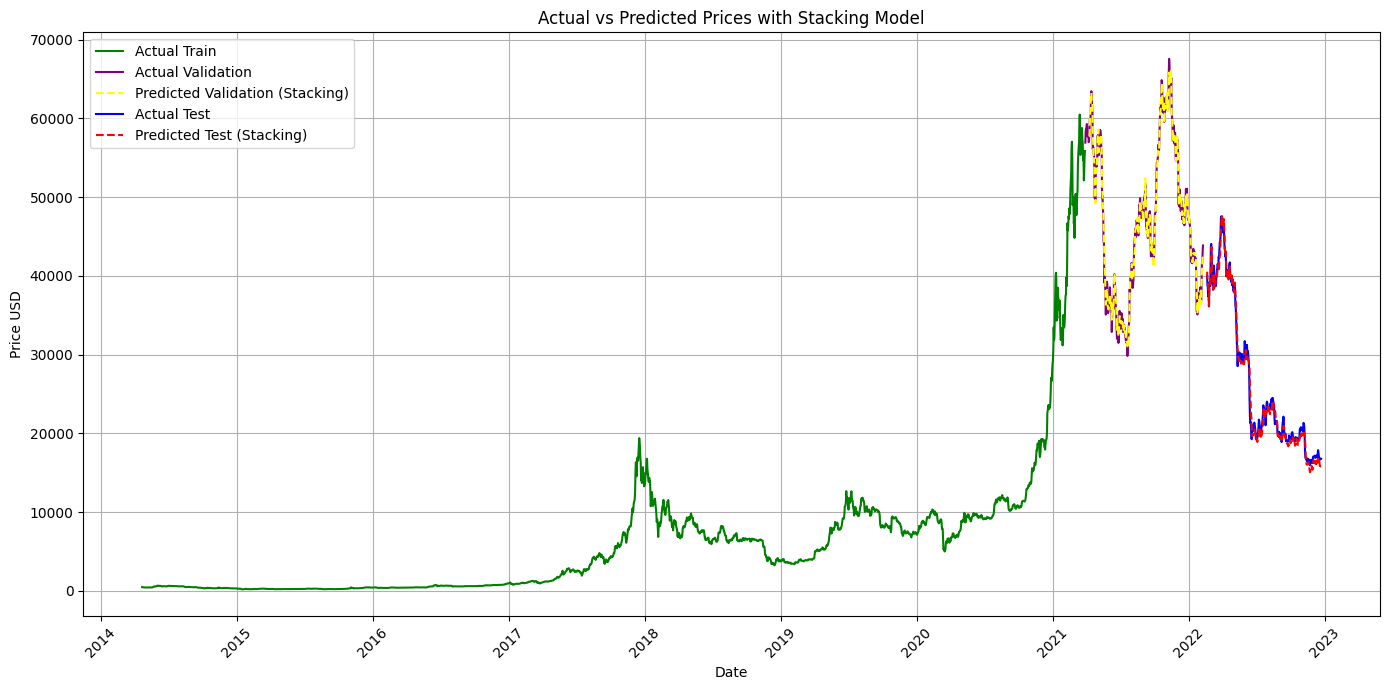

In [79]:
dates_train = df_train['Date']
dates_valid = df_valid['Date']
dates_test = df_test['Date'].iloc[window:]

# --- Biểu đồ tổng hợp Actual và Stacking dự đoán train, valid, test ---
plt.figure(figsize=(14,7))
plt.plot(dates_train, df_train['priceUSD'], label='Actual Train', color='green')
plt.plot(dates_valid, df_valid['priceUSD'], label='Actual Validation', color='purple')
plt.plot(dates_valid.iloc[window:], pred_stack_val_real, label='Predicted Validation (Stacking)', color='yellow', linestyle='--')
plt.plot(dates_test, df_test['priceUSD'].iloc[window:], label='Actual Test', color='blue')
plt.plot(dates_test, pred_stack_test_real, label='Predicted Test (Stacking)', color='red', linestyle='--')
plt.title('Actual vs Predicted Prices with Stacking Model')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Biểu đồ so sánh dự báo giá Bitcoin trên tập test của mô hình LSTM với giá thực tế**

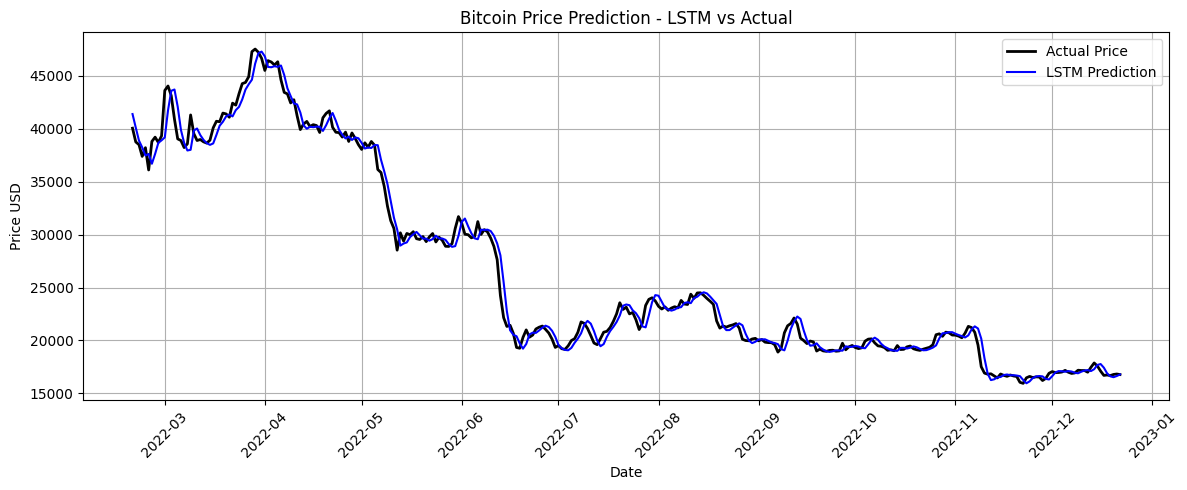

In [73]:
# --- Biểu đồ LSTM ---
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test_real, label='Actual Price', color='black', linewidth=2)
plt.plot(dates_test, pred_lstm_test_real, label='LSTM Prediction', color='blue')
plt.title('Bitcoin Price Prediction - LSTM vs Actual')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Biểu đồ so sánh dự báo giá Bitcoin trên tập test của mô hình LightGBM với giá thực tế**

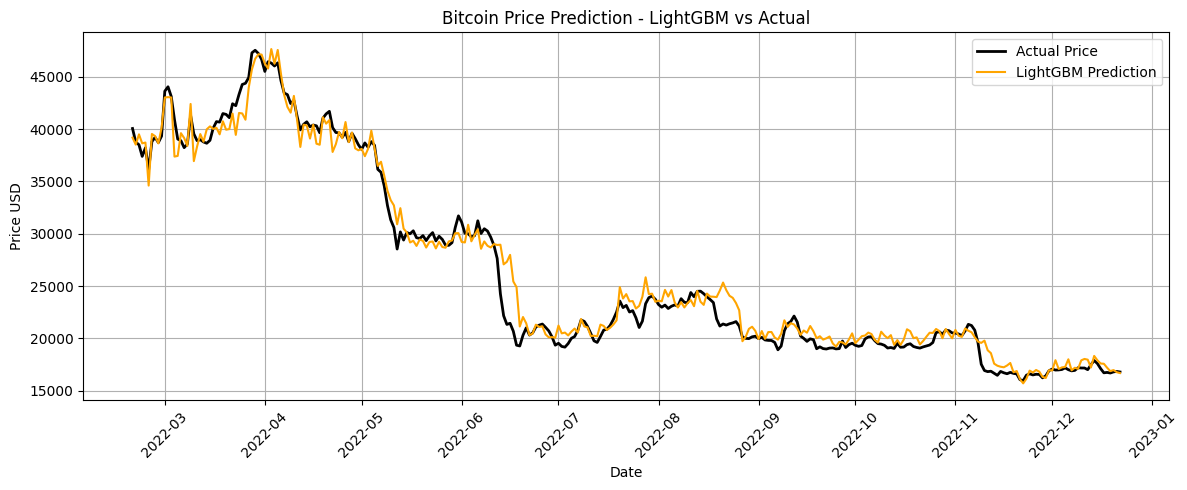

In [74]:
# --- Biểu đồ LightGBM ---
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test_real, label='Actual Price', color='black', linewidth=2)
plt.plot(dates_test, pred_lgb_test_real, label='LightGBM Prediction', color='orange')
plt.title('Bitcoin Price Prediction - LightGBM vs Actual')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Biểu đồ so sánh dự báo giá Bitcoin trên tập test của mô hình Stacking với giá thực tế**

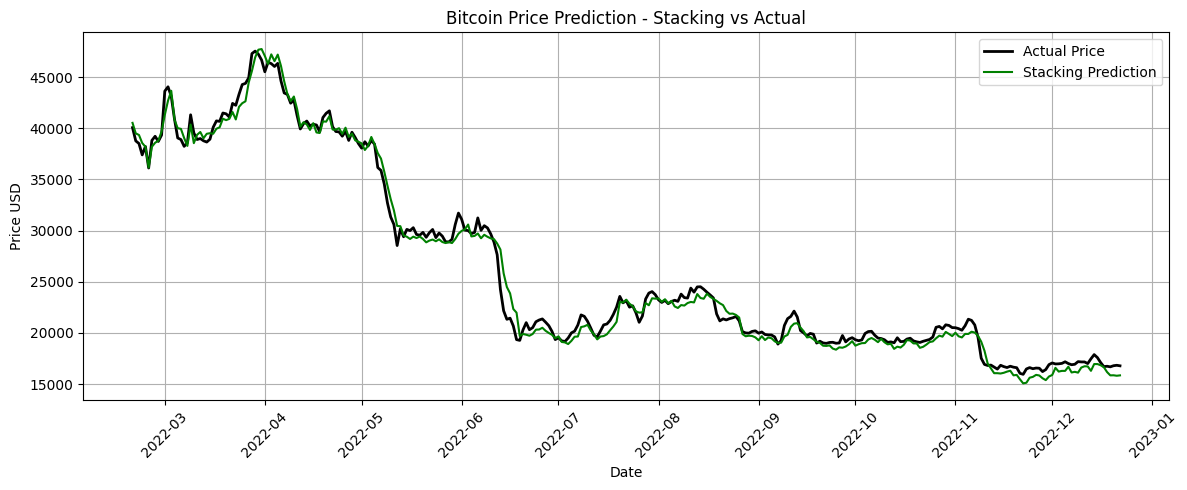

In [75]:
# --- Biểu đồ Stacking ---
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test_real, label='Actual Price', color='black', linewidth=2)
plt.plot(dates_test, pred_stack_test_real, label='Stacking Prediction', color='green')
plt.title('Bitcoin Price Prediction - Stacking vs Actual')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Biểu đồ tổng hợp so sánh dự báo giá Bitcoin của LSTM, LightGBM và Stacking trên tập test**

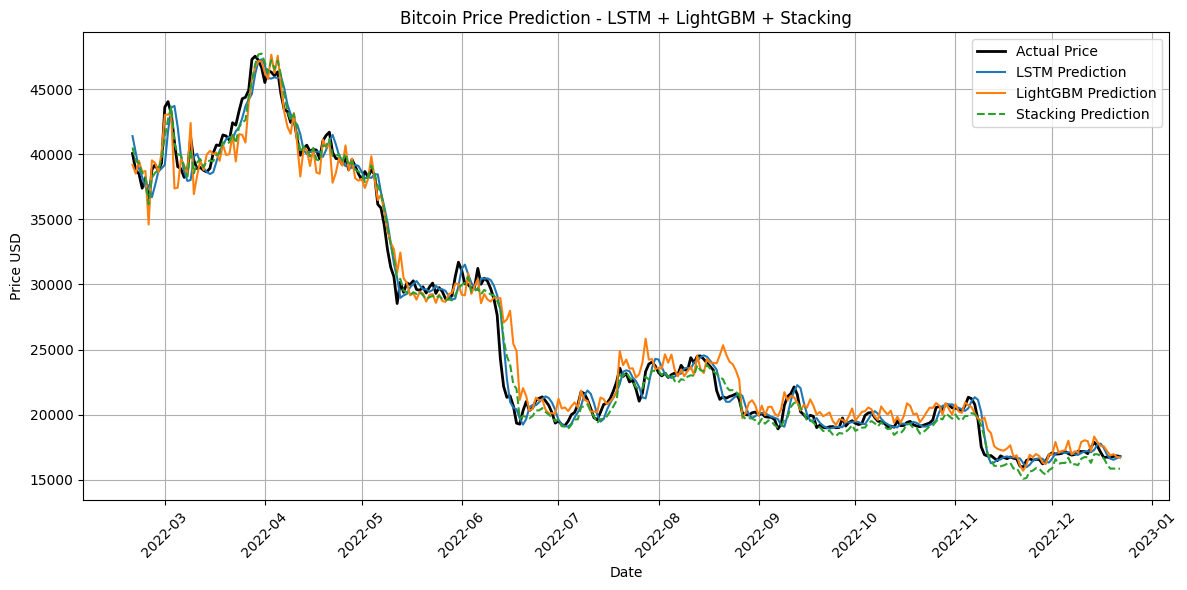

In [76]:
# --- 10. Vẽ biểu đồ gộp ---
plt.figure(figsize=(12,6))
plt.plot(df_test['Date'].iloc[window:], y_test_real, label='Actual Price', color='black', linewidth=2)
plt.plot(df_test['Date'].iloc[window:], pred_lstm_test_real, label='LSTM Prediction')
plt.plot(df_test['Date'].iloc[window:], pred_lgb_test_real, label='LightGBM Prediction')
plt.plot(df_test['Date'].iloc[window:], pred_stack_test_real, label='Stacking Prediction', linestyle='--')
plt.title('Bitcoin Price Prediction - LSTM + LightGBM + Stacking')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()